In [2]:
import sys
sys.path.append("..")
from matplotlib import pyplot as plt
import numpy as np  
from scipy import ndimage
#import cv2
import multi_axis as ma    # custom tomo functions
#import astra   
import copy
#import open3d as o3d    # fast 3d plotting
from grispy import GriSPy # for finding points at given radius fast
import matplotlib
from tqdm import tqdm #progress bar
import sys

%config Completer.use_jedi = False # enable auto-completion of functinos

# To implement the loading bar, instead of writing 'for i in x:'
# Write instead, 'for i in tqdm(x, position=0, leave=True, file=sys.stdout, total=len(x)):'

In [3]:
def swap_cols(arr, frm, to):
    """ Takes 3D array and swaps over two columns"""
    A = copy.deepcopy(arr)
    A = np.transpose(A,axes=(1,0,2))
    return A

def fourier_slices3D(angles, d=100,n=100,lmin=1,N_mult=2,vector_components=False):
    """
    Takes a set of angles (in deg) that define an acquisition scheme
    and returns the compiled Fourier space slices as an array
    
    # Note there will be some innaccuracy due to rounding projection width to int
    # the higher the FS resolution the less noticable, (should be at least 2)
    # lmin is real space width of pixel at highest res of interest
    # d is width of image in nm
    # n is number of pixels across image in one row (assumed square)
    # N_mult is a scalar defining how much more fine your Fourier grid is than your volume
    
    """
    # Create uniform volume of ones
    vol = np.ones((n,n,n))
    
    # initialise fourier image
    # Needs to be at least enough to resolve slice width (i.e. Nyquist N_mult >= 2)
    N = n*N_mult
    final = np.zeros((N,N,N))
    
    # get index of centre
    centre = int(N/2)
    
    # define lengths
    rpx = d/n # real space pixel width
    fpx = 1/rpx / N # fourier space pixel display width
    width = 1/d # fourier space slice width
    width_i = width/fpx # number of fourier space pixels needed to represent slice width

    # project volume at each angle
    proj = ma.generate_proj_data(vol,angles)
    proj = swap_cols(proj,1,0) # ma needs swapping since it was prepared for astra compatibility
    
    # loop over angles and add each projection to fourier image
    
    if vector_components == False:
        for i,a in tqdm(enumerate(angles), position=0, leave=True,total=len(angles),file=sys.stdout):
            # get projected image
            p = proj[i].reshape((n,n,1)) # reshape is to trick into thinking it is a 1 px wide slice in 3D space
                                         # not just a 2D image

            # reshape projection to desired shape - use zooming interpolation algorithm
            #p_resize = cv2.resize(p,dsize=(N,int(width_i/2)*2))
            p_resize = ndimage.zoom(p,(N/n,N/n,int(width_i/2)*2)) # cv2 resize only handles 2d, ndimage zoom for 3d


            # fs is the current fourier slice volume
            fs = np.zeros((N,N,N))

            # central slice of fs becomes projection data
            fs[:,:,centre-int(width_i/2):centre+int(width_i/2)] = p_resize

            # rotate to final position - this is quite slow - might be worth trying to speed up
            #fsr = ma.rotate_bulk(fs,a[0],a[1],a[2])
            fsr = fast_rotate_bulk(fs,a[0],a[1],a[2])

            # add to final fourier space volume
            final += fsr
        
        final = np.clip(final,0,1)
        
        return final
    
    if vector_components == True:
        finalx = np.zeros((N,N,N))
        finaly = np.zeros((N,N,N))
        finalz = np.zeros((N,N,N))
        x = [1,0,0]
        y = [0,1,0]
        z = [0,0,1]
        
        for i,a in enumerate(angles): 
            # get projection
            p = proj[i].reshape((n,n,1))

            # calculate plane normal
            mrot = ma.rotation_matrix(a[0],a[1],a[2])
            normal = np.dot(mrot,[0,0,1])

            # Calculate component weightings
            # when |normal x dir| is high, weighting is high
            # ie if e- direction is perp to component, it is sensitive to M
            comps = []
            for v in [x,y,z]:
                cross = (np.linalg.norm(normal)**2*np.linalg.norm(v)**2-np.dot(normal,v)**2)**.5
                comps.append(cross)

            # reshape projection to desired shape
            p_resize = ndimage.zoom(p,(N/n,N/n,int(width_i/2)*2)) # cv2 resize only handles 2d, ndimage zoom for 3d
            
            # fs is the current fourier slice volume
            fs = np.zeros((N,N,N))

            # central slice becomes projection data
            fs[:,:,centre-int(width_i/2):centre+int(width_i/2)] = p_resize

            # rotate to final position - this is quite slow - might be worth trying to speed up
            #fsr = ma.rotate_bulk(fs,a[0],a[1],a[2])
            fsr = fast_rotate_bulk(fs,a[0],a[1],a[2])
            
            # scale x/y/z slice components by cross product
            # and clip value between 0 and 1
            finalx += fsr*comps[0]
            finalx = np.clip(finalx,0,1)
            finaly += fsr*comps[1]
            finaly = np.clip(finaly,0,1)
            finalz += fsr*comps[2]
            finalz = np.clip(finalz,0,1)

        return finalx,finaly,finalz

def plot3D(fs_volume,inside=None,s=3, black=False):
    """ Take a 3D array of points in Fourier space and plot them interactively in 3D """
    # Convert grid to point cloud
        # Where gets us the coordinates
        # the >0 condition ensures we only take points with non-zero intensity 
        # transpose puts it into the shape required by o3d
    points = np.transpose(np.where(fs_volume[::s,::s,::s]>0))
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    
    # Make all points black
    if black == False:
        pcd.colors = o3d.utility.Vector3dVector(np.zeros_like(points))
    
    # Scale point colour by intensity
    if black != False:
        cmap = matplotlib.cm.get_cmap('Blues')
        shape = np.shape(points)
        cols = np.zeros_like(points,dtype=np.float16)
        for i,p in enumerate(points):
            p = np.array(p)*s # account for skipping
            val = fs_volume[p[0],p[1],p[2]]

            c = cmap(val)
            cols[i,0] = c[0]
            cols[i,1] = c[1]
            cols[i,2] = c[2]
        pcd.colors = o3d.utility.Vector3dVector(cols)
    
    # Plot     
    if inside == None:
        o3d.visualization.draw_geometries([pcd])
    else:
        pcd2 = o3d.geometry.PointCloud()
        pcd2.points = o3d.utility.Vector3dVector((np.array(inside)+100)*66/200)
        pcd2.colors = o3d.utility.Vector3dVector(np.ones_like(points)*.5)
        o3d.visualization.draw_geometries([pcd,pcd2])

def plot3d_orthoslices(vol,plane = 'xz',i_slice=None,d=100,n=100,lmin=1, N_mult=2, save_path = False,ax=None,vmin=None,vmax=None):
    # plot central slice if none given
    if i_slice == None:
        i_slice = int(np.shape(vol)[0]/2)
        
    if ax == None:
        fig,ax = plt.subplots()
        
    if plane == 'xy':
        final = vol[:,:,i_slice]
        ax.set_title('xy - %i/%i' %(i_slice,np.shape(vol)[0]))
        ax.set_xlabel('k$_x$ / nm$^{-1}$')
        ax.set_ylabel('k$_y$ / nm$^{-1}$')

        
    if plane == 'xz':
        final = vol[:,i_slice,:]
        ax.set_title('xz - %i/%i' %(i_slice,np.shape(vol)[0]))
        ax.set_xlabel('k$_x$ / nm$^{-1}$')
        ax.set_ylabel('k$_z$ / nm$^{-1}$')
        
    if plane == 'yz':
        final = vol[i_slice,:,:]
        ax.set_title('yz - %i/%i' %(i_slice,np.shape(vol)[0]))
        ax.set_xlabel('k$_y$ / nm$^{-1}$')
        ax.set_ylabel('k$_z$ / nm$^{-1}$')
        
    N = n*N_mult    
    rpx = d/n # real space pixel width
    fpx = 1/rpx / N # fourier space pixel display width
        
    #display width no. at desired res in FS
    n_fdw = 1/lmin / fpx
    missing = int(n_fdw-N)
        
    # pad final image to get up to resolution
    if missing >= 0:
        extra = 0
        final = np.pad(final,[(missing, missing), (missing, missing)],'constant')
    if missing < 0:
        extra = int(abs(missing)/2)
        final = final[extra:-extra,extra:-extra]

    # set extent to max resoltuion
    res_max = lmin
    fres = 1/res_max
    extent = [-fres/2,fres/2,-fres/2,fres/2]

    ax.imshow(final,cmap='Greys_r',extent=extent,vmin=vmin,vmax=vmax)
    
    
    if save_path != False:
        plt.savefig(save_path)
        
def prepare_radius_search(fs_volume):
    """ Get grid to be used for searching for shell radius """
    crd = np.transpose(np.where(fs_volume>-10))
    gsp = GriSPy(crd)
    n = np.shape(fs_volume)[0]
    c = int(n/2)
    centres = np.array([[c,c,c]])
    
    return gsp, crd, centres

def completeness_ratio(crd,shell_ind,fs_volume,v=None,cone_angle=30,thresh=1,mode='val'):
    """ Given full coordinate space, and indices of points at given radius,
    calculates the ratio of points with/without data
    Currently can try with mode = 'val' or 'thresh' """
    filled_inds = []
    angs = []
    full,tot = 0,0
    # for each point at radius, evaluate value
    cent = int(np.round(np.shape(crd)[0]**(1/3))/2)
    for i in range(len(shell_ind[0])):
        # get vector from origin to point
        ind = np.array(crd[shell_ind[0][i]])-cent
        
        # directional
        if v != None:
            # Calculate angle between v and ind
            angle = np.arccos(np.dot(ind,v)/(np.linalg.norm(ind)*np.linalg.norm(v)))*180/np.pi
            angs.append(angle)

            # If angle is in right direction, evaluate value of point
            if angle < cone_angle or angle > 180-cone_angle:
                val = fs_volume[ind[0]+cent,ind[1]+cent,ind[2]+cent]
                
                if mode == 'thresh':
                    if val >= thresh:
                        full += 1
                        filled_inds.append(ind)
                if mode == 'val':
                    full += val
                tot += 1
                
        # non-directional        
        if v == None:
            val = fs_volume[ind[0]+cent,ind[1]+cent,ind[2]+cent]
            if mode == 'thresh':
                if val >= thresh:
                    full += 1
                    filled_inds.append(ind)
            if mode == 'val':
                full += val
            tot += 1
    
    try:
        rat = full/tot
    except: # avoid divide by zero error
        rat = 0
        
    return rat, filled_inds

def calculate_completeness_series(gsp,centres,crd,fs_volume,extent=40,thresh=1,mode='val',v=None,cone_angle=30):
    rats = []
    for i in tqdm(range(2,extent), position=0, leave=True,file=sys.stdout):
        shell_ind = shell_neighbours(gsp,centres,i)
        rat,_ = completeness_ratio(crd,shell_ind,fs_volume,thresh=thresh,mode=mode,v=v,cone_angle=cone_angle)
        rats.append(rat)

    return rats

def opt_fun(x,crd,fs_volume,v,mode,thresh,gsp,centres):
    shell_ind = shell_neighbours(gsp,centres,int(x))
    dc_ratio,_ = completeness_ratio(crd,shell_ind,fs_volume,v=v,mode=mode,thresh=thresh)
    return abs(0.5-dc_ratio)



def dc_ratio_opt(crd,fs_volume,v,mode,gsp,centres,thresh=None,x0=30,xatol=.5,fatol=.1):
    res = scipy.optimize.minimize(opt_fun,x0,args=(crd,fs_volume,v,mode,thresh,gsp,centres),method='Nelder-mead',
                                  options={'xatol':xatol,'fatol':fatol})
    return int(res.x[0])

def fast_rotate_bulk(P,ax,ay,az):
    """ 
    Rotate magnetisation locations from rotation angles ax,ay,az 
    about the x,y,z axes (given in degrees) 
    
    NOTE: This implementation of scipy rotations is EXTRINSIC
    Therefore, to make it compatible with our intrinsic vector
    rotation, we swap the order of rotations (i.e. x then y then z)
    """
    # Due to indexing, ay needs reversing for desired behaviour
    ay = -ay
    
    P = fast_rotate(P,ax,ind=0)
    P = fast_rotate(P,ay,ind=1)
    P = fast_rotate(P,az,ind=2)
    
#     P = ndimage.rotate(P,ax,reshape=False,axes=(1,2),order=1)
#     P = ndimage.rotate(P,ay,reshape=False,axes=(2,0),order=1)
#     P = ndimage.rotate(P,az,reshape=False,axes=(0,1),order=1)

    return P

from PIL import Image

def fast_rotate(vol,angle,ind=0):
    P = np.zeros_like(vol)

    if ind == 0:
        for i in range(np.shape(vol)[0]):
            im = Image.fromarray(vol[i,:,:]*256).convert('L')
            rot = im.rotate(angle,Image.BILINEAR)
            P[i,:,:] = np.array(rot)/256

    if ind == 1:
        for i in range(np.shape(vol)[1]):
            im = Image.fromarray(vol[:,i,:]*256).convert('L')
            rot = im.rotate(angle,Image.BILINEAR)
            P[:,i,:] = np.array(rot)/256
            
    if ind == 2:
        for i in range(np.shape(vol)[2]):
            im = Image.fromarray(vol[:,:,i]*256).convert('L')
            rot = im.rotate(angle,Image.BILINEAR)
            P[:,:,i] = np.array(rot)/256
            
    return P

import scipy



def shell_neighbours(gsp,centres,lower_radii,rad_range=1):
    """ Takes grid and lower radius value and returns 
    indices of points in the grid that are at that radius """
    upper_radii = lower_radii+rad_range
    shell_dist, shell_ind = gsp.shell_neighbors(
        centres,
        distance_lower_bound=lower_radii,
        distance_upper_bound=upper_radii
    )
    
    return shell_ind




def data_completeness_ratio(shell_ind,crd,thresh=1):
    full = 0
    empty = 0
    #final
    filled_inds = []
    for i in range(len(shell_ind[0])):
        ind = crd[shell_ind[0][i]]
        
        val = final[ind[0],ind[1],ind[2]]
        #print(val)
        if val > thresh:
            full += 1
            filled_inds.append(ind)
        else:
            empty += 1
    return full/(empty+full), filled_inds


def data_completeness_ratio_vec(shell_ind,crd,f,thresh=1):
    vals = 0
    tots = 0
    #final
    filled_inds = []
    for i in range(len(shell_ind[0])):
        ind = crd[shell_ind[0][i]]
        
        val = f[ind[0],ind[1],ind[2]]
        #print(val)
        vals += val
        tots +=1
    return vals/tots, filled_inds

# add directionality

def opt_factory(all_shell_inds):
    # by nesting in this way, all_shell_inds parameter can be returned and updated
    # along with a callable optimisation function - see 'python closure'
    def opt_fun2(x,crd,fs_volume,v,mode,thresh,gsp,centres,all_shell_inds):
        print(x)
        if x < 1:
            x = 1
        try:
            shell_ind = all_shell_inds[str(int(x))]
        except:
            shell_ind = shell_neighbours(gsp,centres,int(x))
            all_shell_inds[str(int(x))] = shell_ind
            
        dc_ratio,_ = completeness_ratio(crd,shell_ind,fs_volume,v=v,mode=mode,thresh=thresh,cone_angle=15)
        
        return abs(0.5-dc_ratio) + 1/(x-int(x))
    
    return opt_fun2, all_shell_inds

def dc_ratio_opt2(crd,fs_volume,v,mode,gsp,centres,all_shell_inds,thresh=None,x0=20,xatol=.5,fatol=.1):
    cons = ({'type':'eq','fun': lambda x : max([x[i]-int(x[i]) for i in range(len(x))])}) # integer
    res = scipy.optimize.minimize(opt_fun2,x0,args=(crd,fs_volume,v,mode,thresh,gsp,centres,all_shell_inds),method='Nelder-mead',
                                  options={'xatol':xatol,'fatol':fatol},constraints=cons,bounds=(1,100))
    return int(res.x[0])

def dc_ratio_opt3(crd,fs_volume,v,mode,gsp,centres,all_shell_inds,thresh=None,x0=20,xatol=.5,fatol=.1,cone_angle=30):
    """ Brute force search for f50 """
    print(v)
    
    rats = []
    
    for i in tqdm(range(2,80), position=0, leave=True,file=sys.stdout):
        shell_ind = shell_neighbours(gsp,centres,i)
        rat,_ = completeness_ratio(crd,shell_ind,fs_volume,thresh=thresh,mode=mode,v=v,cone_angle=cone_angle)
        rats.append(rat)
        if rat < 0.5:
            res = i
            break
        else:
            res = i
            continue

    return res

def clippedcolorbar(CS, **kwargs):
    from matplotlib.cm import ScalarMappable
    from numpy import arange, floor, ceil
    fig = CS.ax.get_figure()
    vmin = CS.get_clim()[0]
    vmax = CS.get_clim()[1]
    m = ScalarMappable(cmap=CS.get_cmap())
    m.set_array(CS.get_array())
    m.set_clim(CS.get_clim())
    step = CS.levels[1] - CS.levels[0]
    cliplower = CS.zmin<vmin
    clipupper = CS.zmax>vmax
    noextend = 'extend' in kwargs.keys() and kwargs['extend']=='neither'
    # set the colorbar boundaries
    boundaries = arange((floor(vmin/step)-1+1*(cliplower and noextend))*step, (ceil(vmax/step)+1-1*(clipupper and noextend))*step, step)
    kwargs['boundaries'] = boundaries
    # if the z-values are outside the colorbar range, add extend marker(s)
    # This behavior can be disabled by providing extend='neither' to the function call
    if not('extend' in kwargs.keys()) or kwargs['extend'] in ['min','max']:
        extend_min = cliplower or ( 'extend' in kwargs.keys() and kwargs['extend']=='min' )
        extend_max = clipupper or ( 'extend' in kwargs.keys() and kwargs['extend']=='max' )
        if extend_min and extend_max:
            kwargs['extend'] = 'both'
        elif extend_min:
            kwargs['extend'] = 'min'
        elif extend_max:
            kwargs['extend'] = 'max'
    return fig.colorbar(m, **kwargs)

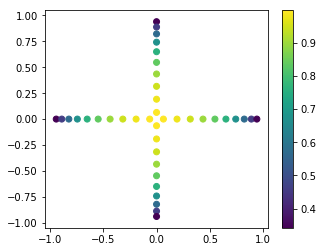

In [6]:
# Define acquisition scheme (to use normals)
v_angs = ma.generate_angles(mode='dual',alpha=70,beta=70,tilt2='gamma',dist_n2=6)
norms = []
for a in v_angs:
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    n = mrot.dot([0,0,1])
    norms.append(n)
    
plt.figure(figsize=(5,4))
plt.scatter(np.take(norms,0,axis=1),np.take(norms,1,axis=1),c=np.take(norms,2,axis=1))
plt.colorbar()

In [7]:
# Calculate Fourier slice representation of acquisition scheme
#final = fourier_slices3D(v_angs) # scalar
finalx,finaly,finalz = fourier_slices3D(v_angs,vector_components=True) 

135

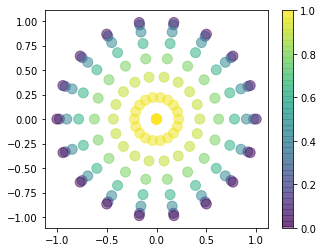

In [12]:
# Define angles to test
#v_angs = ma.generate_angles(mode='dist',alpha=90,tilt2='gamma',dist_n2=6)
v_angs = []
ax = np.linspace(-90,90,15)
az = np.linspace(-90,90,10)
for x in ax:
    for z in az[:-1]:
        v_angs.append([x,0,z])

norms = []
for a in v_angs:
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    n = mrot.dot([0,0,1])
    norms.append(n)
    
plt.figure(figsize=(5,4))
plt.scatter(np.take(norms,0,axis=1),np.take(norms,1,axis=1),c=np.take(norms,2,axis=1),s=100,alpha=.5)
plt.colorbar()
len(v_angs)

105

In [15]:
# For each normal, calculate the resolution at each one
# It uses an optimisation function to speed up finding the 50% coverage zone
final = copy.deepcopy(finalz)
all_shell_inds = {}
all_res = []
gsp,crd,centres = prepare_radius_search(final)
for i,n in enumerate(norms):
    opt_fun2, all_shell_inds = opt_factory(all_shell_inds)
    res = dc_ratio_opt3(crd,final,n.tolist(),'thresh',gsp,centres,all_shell_inds,thresh=1)
    print(i,res)
    all_res.append(res)

[1.0, 6.123233995736766e-17, 6.123233995736766e-17]
 31%|█████████████████████████▏                                                        | 24/78 [00:05<00:12,  4.16it/s]
0 26
[0.8660254037844386, 0.5000000000000001, 6.123233995736766e-17]
 22%|█████████████████▊                                                                | 17/78 [00:03<00:12,  4.98it/s]
1 19
[0.49999999999999994, 0.8660254037844387, 6.123233995736766e-17]
 22%|█████████████████▊                                                                | 17/78 [00:03<00:12,  4.94it/s]
2 19
[0.0, 1.0, 6.123233995736766e-17]
 31%|█████████████████████████▏                                                        | 24/78 [00:05<00:13,  4.12it/s]
3 26
[-0.49999999999999994, 0.8660254037844387, 6.123233995736766e-17]
 22%|█████████████████▊                                                                | 17/78 [00:03<00:12,  4.91it/s]
4 19
[-0.8660254037844386, 0.5000000000000001, 6.123233995736766e-17]
 22%|█████████████████▊      

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


(-1.1, 1.1, -1.1, 1.1)

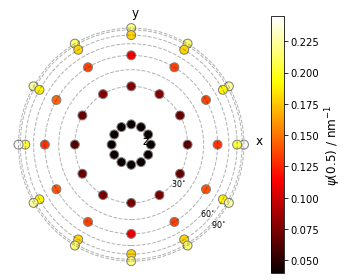

In [284]:
d,n,N_mult=100,100,2
N = n*N_mult    
rpx = d/n
fpx = 1/rpx / N # fourier space pixel display width

plt.figure(figsize=(5,4))
#all_res = all_res_z
plt.scatter(np.take(norms,0,axis=1),np.take(norms,1,axis=1),c=np.array(all_res_x)*fpx,s=80,cmap='hot',edgecolors='gray')
cbar = plt.colorbar()
cbar.set_label('$\psi (0.5)$ / nm$^{-1}$',fontsize=12)
#plt.axis('off')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title('')

thetas = np.linspace(30,90,7)*np.pi/180
z_markers = np.cos(thetas)
R = np.tan(thetas)*z_markers
#R = np.sin(thetas)/(1-np.cos(thetas))
#R = 1/(np.tan(thetas/2))
#z_markers=z
#R = np.divide(1, 1-z_markers, out=np.zeros_like(z_markers), where= (1-z_markers)!=0)

#R = (X**2 + Y**2)**.5
ax = plt.gca()
for i,r in enumerate(R):
    c = plt.Circle([0,0],radius=r,color='k',linestyle='--',alpha=.3,fill=False)
    ax.add_patch(c)
    
    xlab = r*np.cos(-np.pi/4)
    ylab = -xlab
    s = str(thetas[i]*180/np.pi)
    print(type(s))
    if i%3 == 0:
        plt.text(xlab,ylab,'%i$^{\circ}$' % np.round((thetas[i]*180/np.pi)),fontsize=8)

plt.text(0.1,0,'z',fontsize=12)
plt.text(1.1,0,'x',fontsize=12)
plt.text(0,1.1,'y',fontsize=12)
plt.axis('off')

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


(-1.1, 1.1, -1.1, 1.1)

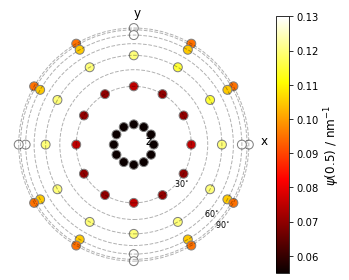

In [270]:
d,n,N_mult=100,100,2
N = n*N_mult    
rpx = d/n
fpx = 1/rpx / N # fourier space pixel display width

phis = []
thetas = []
rs = []

for n in norms:
    r = (n[0]**2+n[1]**2+n[2]**2)**.5
    theta = np.arccos(n[2]/r)
    phi = np.arctan2(n[1],n[0])
    phis.append(phi)
    thetas.append(theta)
    rs.append(r)

# X = R * np.sin(PHI) * np.cos(THETA)
# Y = R * np.sin(PHI) * np.sin(THETA)
# Z = R * np.cos(PHI)

print(rs)

plt.figure(figsize=(5,4))
#all_res = all_res_z
plt.scatter(np.take(norms,0,axis=1),np.take(norms,1,axis=1),c=np.array(all_res)*fpx,s=80,cmap='hot',edgecolors='gray')
cbar = plt.colorbar()
cbar.set_label('$\psi (0.5)$ / nm$^{-1}$',fontsize=12)
#plt.axis('off')
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.title('')

thetas = np.linspace(30,90,7)*np.pi/180
z_markers = np.cos(thetas)
R = np.tan(thetas)*z_markers
#R = np.sin(thetas)/(1-np.cos(thetas))
#R = 1/(np.tan(thetas/2))
#z_markers=z
#R = np.divide(1, 1-z_markers, out=np.zeros_like(z_markers), where= (1-z_markers)!=0)

#R = (X**2 + Y**2)**.5
ax = plt.gca()
for i,r in enumerate(R):
    c = plt.Circle([0,0],radius=r,color='k',linestyle='--',alpha=.3,fill=False)
    ax.add_patch(c)
    
    xlab = r*np.cos(-np.pi/4)
    ylab = -xlab
    s = str(thetas[i]*180/np.pi)
    print(type(s))
    if i%3 == 0:
        plt.text(xlab,ylab,'%i$^{\circ}$' % np.round((thetas[i]*180/np.pi)),fontsize=8)

plt.text(0.1,0,'z',fontsize=12)
plt.text(1.1,0,'x',fontsize=12)
plt.text(0,1.1,'y',fontsize=12)
plt.axis('off')

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


Text(0, 4.1, 'y')

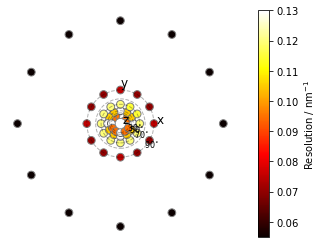

In [269]:
x = np.take(norms,0,axis=1)
y = np.take(norms,1,axis=1)
z = np.take(norms,2,axis=1)
X = np.divide(x, 1-z, out=np.zeros_like(x), where= (1-z)!=0)
Y = np.divide(y, 1-z, out=np.zeros_like(x), where= (1-z)!=0)

plt.axes().set_aspect('equal')

thetas = np.linspace(30,90,7)*np.pi/180
#z_markers = np.cos(thetas)
#R = np.sin(thetas)/(1-np.cos(thetas))
R = 1/(np.tan(thetas/2))
#z_markers=z
#R = np.divide(1, 1-z_markers, out=np.zeros_like(z_markers), where= (1-z_markers)!=0)

#R = (X**2 + Y**2)**.5
ax = plt.gca()
for i,r in enumerate(R):
    c = plt.Circle([0,0],radius=r,color='k',linestyle='--',alpha=.3,fill=False)
    ax.add_patch(c)
    
    xlab = r*np.cos(-np.pi/4)
    ylab = -xlab
    s = str(thetas[i]*180/np.pi)
    print(type(s))
    if i%2 == 0:
        plt.text(xlab,ylab,'%i$^{\circ}$' % (120 - thetas[i]*180/np.pi),fontsize=8)

plt.scatter(X,Y,s=60,c=np.array(all_res)*fpx,cmap='hot',edgecolors='gray')
plt.axis('off')
cbar = plt.colorbar()
cbar.set_label('Resolution / nm$^{-1}$')
plt.text(0.2,0,'z',fontsize=12)
plt.text(4,0,'x',fontsize=12)
plt.text(0,4.1,'y',fontsize=12)


In [136]:
# pay attention!!!
all_res_z=all_res

[-3.14159265e+00 -2.61799388e+00 -2.09439510e+00 -1.57079633e+00
 -1.04719755e+00 -5.23598776e-01 -5.23598776e-01  6.12323400e-17
  5.23598776e-01  5.23598776e-01  1.04719755e+00  1.57079633e+00
  2.09439510e+00  2.61799388e+00]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


C:\Users\grl31\AppData\Local\Temp/ipykernel_6740/2899770592.py:30: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cs.cmap.set_under('k')


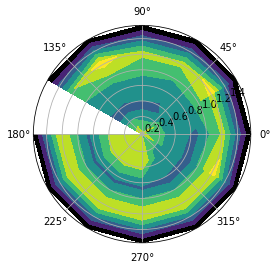

In [229]:
#def plot_map(all_res,norms):
phis = []
thetas = []

for n in norms:
    r = (n[0]**2+n[1]**2+n[2]**2)**.5
    theta = np.arccos(n[2]/r)
    phi = np.arctan2(n[1],n[0])
    phis.append(phi)
    thetas.append(theta)

thetas = np.unique(thetas)
phis = np.unique(phis)

#phis = np.linspace(0, 360, 6)
num_phis = len(phis)
#thetas = np.linspace(0, 90, 10)
num_thetas = len(thetas)
print(phis)
values = np.zeros((num_thetas, num_phis))
for i in range(num_thetas-1):
    for j in range(num_phis):
        theta = np.deg2rad(thetas[i])
        phi = np.deg2rad(phis[j])
        print(i*num_phis+j)
        values[i, j] =all_res[i*num_phis+j]

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
cs = ax.contourf(phis, thetas,values, extend="both")
cs.cmap.set_under('k')

In [224]:
num_thetas,num_phis

(5, 14)

In [226]:
len(all_res)
5*14

70

In [8]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [9]:
def closest_match(params,theta,phi):
    thetag,phig = params
    return abs(theta-thetag) + abs(phi-phig)


res = scipy.optimize.minimize(closest_match,[0,0],args=(theta,phi),method='Nelder-mead')
res.x[0]

NameError: name 'theta' is not defined

In [257]:
f = scipy.interpolate.interp2d(myphis,mythetas,all_res,kind='cubic')

C:\Users\grl31\miniconda3\envs\sandbox\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=14,11 m=60 fp=27.913071 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


In [268]:
f(0,0)

array([11.])

In [297]:
theta = np.deg2rad(0)
phi = np.deg2rad(0)

f(phi,theta)

array([26.])

In [306]:
for i,n in enumerate(norms):
    print(n, np.rad2deg(myphis[i]), np.rad2deg(mythetas[i]), all_res[i])

[1.000000e+00 6.123234e-17 6.123234e-17] 3.508354649267438e-15 3.508354649267438e-15 26
[8.66025404e-01 5.00000000e-01 6.12323400e-17] 30.00000000000001 3.508354649267438e-15 19
[5.00000000e-01 8.66025404e-01 6.12323400e-17] 60.00000000000001 3.508354649267438e-15 19
[0.000000e+00 1.000000e+00 6.123234e-17] 90.0 3.508354649267438e-15 26
[-5.00000000e-01  8.66025404e-01  6.12323400e-17] 119.99999999999999 3.508354649267438e-15 19
[-8.66025404e-01  5.00000000e-01  6.12323400e-17] 150.0 3.508354649267438e-15 19
[9.39692621e-01 5.75395780e-17 3.42020143e-01] 3.508354649267438e-15 20.000000000000007 26
[0.81379768 0.46984631 0.34202014] 30.00000000000001 20.000000000000007 21
[0.46984631 0.81379768 0.34202014] 60.00000000000001 20.000000000000007 21
[0.         0.93969262 0.34202014] 90.0 20.000000000000007 26
[-0.46984631  0.81379768  0.34202014] 119.99999999999999 20.000000000000007 21
[-0.81379768  0.46984631  0.34202014] 150.0 20.000000000000007 21
[7.66044443e-01 4.69066938e-17 6.42787

In [10]:
def clippedcolorbar(CS, **kwargs):
    from matplotlib.cm import ScalarMappable
    from numpy import arange, floor, ceil
    fig = CS.ax.get_figure()
    vmin = CS.get_clim()[0]
    vmax = CS.get_clim()[1]
    m = ScalarMappable(cmap=CS.get_cmap())
    m.set_array(CS.get_array())
    m.set_clim(CS.get_clim())
    step = CS.levels[1] - CS.levels[0]
    cliplower = CS.zmin<vmin
    clipupper = CS.zmax>vmax
    noextend = 'extend' in kwargs.keys() and kwargs['extend']=='neither'
    # set the colorbar boundaries
    boundaries = arange((floor(vmin/step)-1+1*(cliplower and noextend))*step, (ceil(vmax/step)+1-1*(clipupper and noextend))*step, step)
    kwargs['boundaries'] = boundaries
    # if the z-values are outside the colorbar range, add extend marker(s)
    # This behavior can be disabled by providing extend='neither' to the function call
    if not('extend' in kwargs.keys()) or kwargs['extend'] in ['min','max']:
        extend_min = cliplower or ( 'extend' in kwargs.keys() and kwargs['extend']=='min' )
        extend_max = clipupper or ( 'extend' in kwargs.keys() and kwargs['extend']=='max' )
        if extend_min and extend_max:
            kwargs['extend'] = 'both'
        elif extend_min:
            kwargs['extend'] = 'min'
        elif extend_max:
            kwargs['extend'] = 'max'
    return fig.colorbar(m, **kwargs)

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\ipykernel_launcher.py:46: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))
C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\ipykernel_launcher.py:438: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


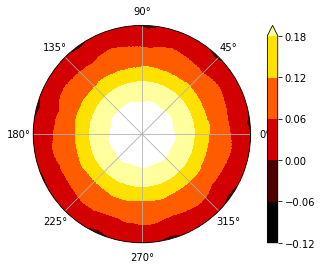

In [18]:
d,n,N_mult=100,100,2
N = n*N_mult    
rpx = d/n
fpx = 1/rpx / N # fourier space pixel display width

myphis = []
mythetas = []

for n in norms:
    r = (n[0]**2+n[1]**2+n[2]**2)**.5
    theta = np.arctan2(n[2],(n[0]**2+n[1]**2)**0.5)
    phi = np.arctan2(n[1],n[0])
    myphis.append(phi)
    mythetas.append(theta)

# myphis=  np.array([0,90,180,270,360,  0,90,180,270,360])/np.pi*180
# mythetas=  90/np.pi*180-np.array([0,0,0,0,0, 45,45,45,45,45 ])/np.pi*180
# res=[28,28,28,28,28,  15,15,15,15,15]

# myphis=  np.array([0,90,180,270,360,  0,90,180,270,360, 45,135,225,315,  0,90])/180*np.pi
# mythetas=  np.array([0,0,0,0,0, 45,45,45,45,45,  1,1,1,1, 90,90])/180*np.pi
# res=[28,28,28,28,28,  22,22,22,22,22, 22,22,22,22,  1,1]



f = scipy.interpolate.interp2d(myphis,mythetas,allx,kind='linear')

phis = np.linspace(0, 360, 520)
num_phis = len(phis)
thetas = np.linspace(0, 90, 180)
num_thetas = len(thetas)

values = np.zeros((num_thetas, num_phis))
for i in range(num_thetas):
    for j in range(num_phis):
        theta = np.deg2rad(thetas[i])
        phi = np.deg2rad(phis[j])
            
        values[i, j] = f(phi,theta)

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
cs = ax.contourf(phis, thetas, values*fpx,cmap='hot',vmax=0.24)
ax.set_rmax(90)
ax.set_rticks([])
#ax.set_xticks([])
cs.cmap.set_under('k')
colorbar = clippedcolorbar(cs)

C:\Users\grl31\AppData\Local\Temp/ipykernel_6740/887905165.py:41: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))
  cs.cmap.set_under('k')
C:\Users\grl31\AppData\Local\Temp/ipykernel_6740/316119288.py:4: MatplotlibDeprecationWarning: 
The ax attribute was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig = CS.ax.get_figure()


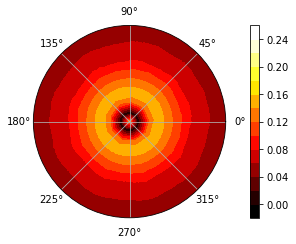

In [405]:
myphis = []
mythetas = []

for n in norms:
    r = (n[0]**2+n[1]**2+n[2]**2)**.5
    theta = np.arctan2(n[2],(n[0]**2+n[1]**2)**0.5)
    phi = np.arctan2(n[1],n[0])
    myphis.append(phi)
    mythetas.append(theta)

# myphis=  np.array([0,90,180,270,360,  0,90,180,270,360])/np.pi*180
# mythetas=  90/np.pi*180-np.array([0,0,0,0,0, 45,45,45,45,45 ])/np.pi*180
# res=[28,28,28,28,28,  15,15,15,15,15]

# myphis=  np.array([0,90,180,270,360,  0,90,180,270,360, 45,135,225,315,  0,90])/180*np.pi
# mythetas=  np.array([0,0,0,0,0, 45,45,45,45,45,  1,1,1,1, 90,90])/180*np.pi
# res=[28,28,28,28,28,  22,22,22,22,22, 22,22,22,22,  1,1]



f = scipy.interpolate.interp2d(myphis,mythetas,all_res_z,kind='linear')

phis = np.linspace(0, 360, 520)
num_phis = len(phis)
thetas = np.linspace(0, 90, 180)
num_thetas = len(thetas)

values = np.zeros((num_thetas, num_phis))
for i in range(num_thetas):
    for j in range(num_phis):
        theta = np.deg2rad(thetas[i])
        phi = np.deg2rad(phis[j])
            
        values[i, j] = f(phi,theta)

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
cs = ax.contourf(phis, thetas, values*fpx,cmap='hot',vmax=0.24)
ax.set_rmax(90)
ax.set_rticks([])
#ax.set_xticks([])
cs.cmap.set_under('k')
colorbar = clippedcolorbar(cs)

In [180]:
myphis

[6.123233995736766e-17,
 0.523598775598299,
 1.0471975511965979,
 1.5707963267948966,
 2.0943951023931953,
 2.6179938779914944,
 6.123233995736766e-17,
 0.523598775598299,
 1.0471975511965979,
 1.5707963267948966,
 2.0943951023931953,
 2.6179938779914944,
 6.123233995736766e-17,
 0.523598775598299,
 1.0471975511965979,
 1.5707963267948966,
 2.0943951023931953,
 2.6179938779914944,
 6.123233995736766e-17,
 0.5235987755982989,
 1.0471975511965979,
 1.5707963267948966,
 2.0943951023931953,
 2.6179938779914944,
 6.123233995736766e-17,
 0.5235987755982989,
 1.0471975511965979,
 1.5707963267948966,
 2.0943951023931953,
 2.6179938779914944,
 -3.141592653589793,
 -2.6179938779914944,
 -2.0943951023931953,
 -1.5707963267948966,
 -1.0471975511965979,
 -0.5235987755982989,
 -3.141592653589793,
 -2.6179938779914944,
 -2.0943951023931953,
 -1.5707963267948966,
 -1.0471975511965979,
 -0.5235987755982989,
 -3.141592653589793,
 -2.6179938779914944,
 -2.0943951023931953,
 -1.5707963267948966,
 -1.04719

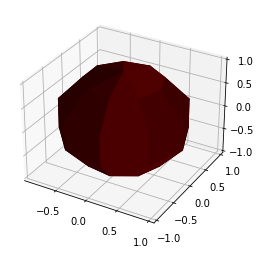

In [247]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
r = 0.05
u, v = np.mgrid[0:2 * np.pi:10j, 0:np.pi:6j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)

from matplotlib import cm

# simulate heat pattern (striped)
myheatmap = np.reshape(all_res,(10,6))

#ax.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.hot(myheatmap))


ax.plot_surface(x, y, z,facecolors=cm.hot(myheatmap),cmap='hot' )
plt.show()

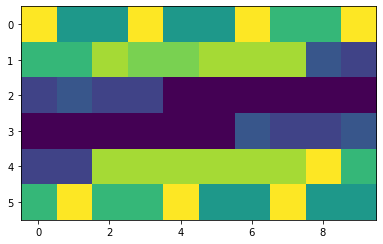

In [243]:
plt.scatter(np.reshape(all_res,(6,10)))

TypeError: Input z must be 2D, not 1D

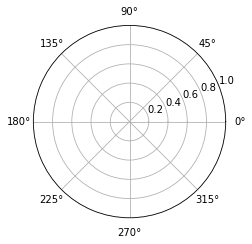

In [251]:
def plotcnt():
    import matplotlib.pyplot as plt
    import numpy as np
    azimuths = np.radians(np.linspace(0, 360, 360))
    zeniths = np.linspace(0, 2.1,20)
    r,theta=np.meshgrid(zeniths,azimuths)

    values= r*np.log(theta+2)


    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    ax.contourf(theta, r, values)
    plt.show()

plotcnt()

C:\Users\grl31\miniconda3\envs\sandbox\lib\site-packages\scipy\interpolate\_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=13,8 m=60 fp=12.500000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


# Test

In [122]:
def dc_ratio_opt3(crd,fs_volume,v,mode,gsp,centres,all_shell_inds,thresh=None,x0=20,xatol=.5,fatol=.1):
    """ Brute force search for f50 """
    print(v)
    for i in tqdm(range(2,80), position=0, leave=True,file=sys.stdout):
        shell_ind = shell_neighbours(gsp,centres,i)
        rat,_ = completeness_ratio(crd,shell_ind,fs_volume,thresh=thresh,mode=mode,v=v)
        rats.append(rat)
        if rat < 0.5:
            res = i
            break
        else:
            res = i
            continue

    return res

In [123]:
res = dc_ratio_opt3(crd,final,norms[0].tolist(),'thresh',gsp,centres,all_shell_inds,thresh=1)

[1.0, 6.123233995736766e-17, 6.123233995736766e-17]
 60%|█████████████████████████████████████████████████▍                                | 47/78 [00:34<00:22,  1.37it/s]


In [119]:
res

49

In [56]:
def opt_fun2(x,crd,fs_volume,v,mode,thresh,gsp,centres,all_shell_inds):
        print(x)
        if x < 1:
            x = 1
        try:
            shell_ind = all_shell_inds[str(int(x))]
        except:
            shell_ind = shell_neighbours(gsp,centres,int(x))
            all_shell_inds[str(int(x))] = shell_ind
            
        dc_ratio,_ = completeness_ratio(crd,shell_ind,fs_volume,v=v,mode=mode,thresh=thresh,cone_angle=15)
        
        return abs(0.5-dc_ratio) + 1/(x-int(x))

In [58]:
res = scipy.optimize.differential_evolution(opt_fun2, bounds=[(0,100)],args=(crd,fs_volume,v,mode,thresh,gsp,centres,all_shell_inds))

NameError: name 'fs_volume' is not defined

In [124]:
all_rat = []
for t in [1]:
    rats = calculate_completeness_series(gsp,centres,crd,final,extent=50,thresh=t,mode='thresh',v=[1.0, 6.123233995736766e-17, 6.123233995736766e-17])
    all_rat.append(rats)

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:31<00:00,  1.50it/s]


0.5050479555779909

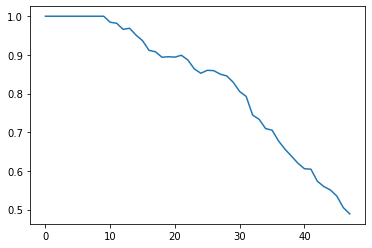

In [129]:
plt.plot(all_rat[0])
all_rat[0][46]

In [383]:
fpx

0.005

In [406]:
def generate_angles(mode='x',n_tilt = 40, alpha=70,beta=40,gamma=180,dist_n2=8,tilt2='gamma'):
    """ Return a list of [ax,ay,az] lists, each corresponding to axial
    rotations applied to [0,0,1] to get a new projection direction.
    
    Modes = x, y, dual, quad, sync, dist, rand
    
    Specify the +- tilt range of alpha/beta/gamma
    
    Say total number of tilts n_tilt
    
    For dist, each alpha has 'dist_n2' 'tilt2' projections
    
    Specify if the 2nd tilt axis is beta or gamma """
    
    angles = []
    ax,ay,az = 0,0,0
    
    # x series
    if mode=='x':
        for ax in np.linspace(-alpha,alpha,n_tilt):
            angles.append([ax,ay,az])
            
    if mode=='y':
        if tilt2 == 'beta':
            for ay in np.linspace(-beta,beta,n_tilt):
                angles.append([ax,ay,az])
        if tilt2 == 'gamma':
            if gamma >= 90:
                az = 90
            else:
                az = gamma
            for ax in np.linspace(-alpha,alpha,n_tilt):
                angles.append([ax,ay,az])
            
    if mode=='dual':
        for ax in np.linspace(-alpha,alpha,int(n_tilt/2)):
            angles.append([ax,ay,az])
            
        ax,ay,az = 0,0,0
        if tilt2 == 'beta':
            for ay in np.linspace(-beta,beta,int(n_tilt/2)):
                angles.append([ax,ay,az])
        if tilt2 == 'gamma':
            if gamma >=90:
                az = 90
            else:
                az = gamma
            for ax in np.linspace(-alpha,alpha,int(n_tilt/2)):
                angles.append([ax,ay,az])
    
    if mode=='quad':
        if tilt2 == 'beta':
            for ax in np.linspace(-alpha,alpha,int(n_tilt/4)):
                angles.append([ax,ay,az])
                
            ax,ay,az = 0,0,0
            for ay in np.linspace(-beta,beta,int(n_tilt/4)):
                angles.append([ax,ay,az])
                
            if beta >=45:
                ay = 45
            else:
                ay = beta
            for ax in np.linspace(-alpha,alpha,int(n_tilt/4)):
                angles.append([ax,ay,az])
                
            if beta >=45:
                ay = -45
            else:
                ay = -beta
            for ax in np.linspace(-alpha,alpha,int(n_tilt/4)):
                angles.append([ax,ay,az])
                    
        if tilt2 == 'gamma':
            if gamma >= 90:
                for ax in np.linspace(-alpha,alpha,int(n_tilt/4)):
                    angles.append([ax,ay,az])
                az = 90
                for ax in np.linspace(-alpha,alpha,int(n_tilt/4)):
                    angles.append([ax,ay,az])
                az = 45
                for ax in np.linspace(-alpha,alpha,int(n_tilt/4)):
                    angles.append([ax,ay,az])
                az = -45
                for ax in np.linspace(-alpha,alpha,int(n_tilt/4)):
                        angles.append([ax,ay,az])           
            else:
                az = gamma
                for ax in np.linspace(-alpha,alpha,n_tilt/4):
                    angles.append([ax,ay,az])
                az = -gamma
                for ax in np.linspace(-alpha,alpha,n_tilt/4):
                    angles.append([ax,ay,az])
                az = gamma/3
                for ax in np.linspace(-alpha,alpha,n_tilt/4):
                    angles.append([ax,ay,az])
                az = -gamma/3
                for ax in np.linspace(-alpha,alpha,n_tilt/4):
                    angles.append([ax,ay,az])

    # random series # g or b
    if mode=='rand':
        for i in range(n_tilt):
            ax_rand = np.random.rand()*alpha*2 - alpha
            if tilt2 == 'beta':
                ay_rand = np.random.rand()*beta*2 - beta
                angles.append([ax_rand,ay_rand,0])
            if tilt2 == 'gamma':
                az_rand = np.random.rand()*gamma*2 - gamma
                angles.append([ax_rand,0,az_rand])
            
    # alpha propto beta series # g or b
    if mode=='sync':
        if tilt2 == 'beta': 
            ax = np.linspace(-alpha,alpha,int(n_tilt/2))
            ay = np.linspace(-beta,beta,int(n_tilt/2))

            for i,a in enumerate(ax):
                angles.append([a,ay[i],0])

            for i,a in enumerate(ax):
                angles.append([a,-ay[i],0])
        if tilt2 == 'gamma': 
            ax = np.linspace(-alpha,alpha,int(n_tilt/2))
            az = np.linspace(-gamma,gamma,int(n_tilt/2))

            for i,a in enumerate(ax):
                angles.append([a,0,az[i]])

            for i,a in enumerate(ax):
                angles.append([a,0,-az[i]])
            
    # even spacing # g or b
    if mode=='dist':
        ax = np.linspace(-alpha,alpha,int(n_tilt/dist_n2))
        if alpha == 90:
            ax = np.linspace(-90,90,n_tilt/dist_n2+1)
            ax = ax[::-1]
        if tilt2 == 'beta': 
            ay = np.linspace(-beta,beta,dist_n2)
            for x in ax:
                for y in ay:
                    angles.append([x,y,0])
        if tilt2 == 'gamma': 
            if gamma < 90:
                az = np.linspace(-gamma,gamma,dist_n2)
                for x in ax:
                    for z in az:
                        angles.append([x,0,z])
            if gamma >= 90:
                az = np.linspace(-90,90,dist_n2+1)
                for x in ax:
                    for z in az[:-1]:
                        angles.append([x,0,z])
                        
    return angles

In [427]:
    import matplotlib.font_manager
    import matplotlib
    # Set font and colormap for plotting
    font = {'family':'sans-serif','sans-serif':['Arial'],
            'size'   : 14}
    matplotlib.rc('font', **font)

C:\Users\grl31\AppData\Local\Temp/ipykernel_6740/1240957048.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


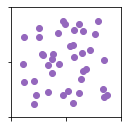

In [429]:
i=6
modes = ['x','y','dual','quad','sync','dist','rand']
mode = modes[i]
cols = ['k','gray','tab:blue','tab:orange','tab:green','tab:red','tab:purple']

angles = generate_angles(mode=mode,alpha=70,gamma=180,beta=70,tilt2='beta',n_tilt=40,dist_n2=8)


plt.figure(figsize=(2,2))
for a in angles:
    if i!= 1:
        plt.scatter(a[0],a[1],color=cols[i])
    else:
        plt.scatter(a[0],a[1],edgecolor=cols[i],facecolor='w')
    
# plt.xlim([-94,94])
# plt.ylim([-94,94])
# plt.xticks([-90,0,90])
# plt.yticks([-90,0,90])
# plt.xlabel(r'$\alpha (^{\circ})$')
# plt.ylabel(r'$\beta (^{\circ})$')

plt.xticks([-90,0,90],labels=['','',''])
plt.yticks([-90,0,90],labels=['','',''])

plt.axes().set_aspect('equal')
plt.tight_layout()

# Full process

In [251]:
def calculate_DVR(mode='dual',alpha=70,beta=70,n_tilt=40):
    # Define acquisition scheme (to use normals)
    v_angs = ma.generate_angles(mode=mode,alpha=alpha,beta=beta,n_tilt=n_tilt)
    norms = []
    for a in v_angs:
        mrot = ma.rotation_matrix(a[0],a[1],a[2])
        n = mrot.dot([0,0,1])
        norms.append(n)

    # Calculate Fourier slice representation of acquisition scheme
    finalx,finaly,finalz = fourier_slices3D(v_angs,vector_components=True) 
    
    # Define angles to test
    v_angs = []
    ax = np.linspace(-90,90,11)
    az = np.linspace(-90,90,5)
    for x in ax:
        for z in az[:-1]:
            v_angs.append([x,0,z])

    norms = []
    for a in v_angs:
        mrot = ma.rotation_matrix(a[0],a[1],a[2])
        n = mrot.dot([0,0,1])
        norms.append(n)

    # For each normal, calculate the resolution at each one
    all_all_res = []
    for final in finalx,finaly,finalz:
        final = copy.deepcopy(final)
        all_shell_inds = {}
        all_res = []
        gsp,crd,centres = prepare_radius_search(final)
        for i,n in enumerate(norms):
            opt_fun2, all_shell_inds = opt_factory(all_shell_inds)
            res = dc_ratio_opt3(crd,final,n.tolist(),'thresh',gsp,centres,all_shell_inds,thresh=1,cone_angle=15)
            print(i,res)
            all_res.append(res)
        all_all_res.append(all_res)
        
    all_res_x,all_res_y,all_res_z = all_all_res
    
    return all_res_x,all_res_y,all_res_z

def plot_DVR(all_res):
    # Define angles to test
    v_angs = []
    ax = np.linspace(-90,90,11)
    az = np.linspace(-90,90,5)
    for x in ax:
        for z in az[:-1]:
            v_angs.append([x,0,z])

    norms = []
    for a in v_angs:
        mrot = ma.rotation_matrix(a[0],a[1],a[2])
        n = mrot.dot([0,0,1])
        norms.append(n)
    
    
    d,n,N_mult=100,100,2
    N = n*N_mult    
    rpx = d/n
    fpx = 1/rpx / N # fourier space pixel display width

    myphis = []
    mythetas = []

    for i,n in enumerate(norms):
        r = (n[0]**2+n[1]**2+n[2]**2)**.5
        theta = np.arctan2(n[2],(n[0]**2+n[1]**2)**0.5)
        phi = np.arctan2(n[1],n[0])
        myphis.append(phi)
        mythetas.append(theta)
       # print(v_angs[i],'theta %.3f, phi %.2f' %(theta,phi))

    # myphis=  np.array([0,90,180,270,360,  0,90,180,270,360])/np.pi*180
    # mythetas=  90/np.pi*180-np.array([0,0,0,0,0, 45,45,45,45,45 ])/np.pi*180
    # res=[28,28,28,28,28,  15,15,15,15,15]

    # myphis=  np.array([0,90,180,270,360,  0,90,180,270,360, 45,135,225,315,  0,90])/180*np.pi
    # mythetas=  np.array([0,0,0,0,0, 45,45,45,45,45,  1,1,1,1, 90,90])/180*np.pi
    # res=[28,28,28,28,28,  22,22,22,22,22, 22,22,22,22,  1,1]



    f = scipy.interpolate.interp2d(myphis,mythetas,all_res,kind='linear')

    phis = np.linspace(0, 360, 520)
    num_phis = len(phis)
    thetas = np.linspace(0, 90, 180)
    num_thetas = len(thetas)

    values = np.zeros((num_thetas, num_phis))
    for i in range(num_thetas):
        for j in range(num_phis):
            theta = np.deg2rad(thetas[i])
            phi = np.deg2rad(phis[j])

            values[i, j] = f(phi,theta)

    fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
    # should be theta, r?
    #cs = ax.contourf(phis, thetas, values*fpx,cmap='hot',vmax=.5)
    rs = np.cos(thetas*np.pi/180)
    myrs = np.cos(np.array(mythetas)*np.pi/180)
    #cs = ax.contourf(phis, rs, values*fpx,cmap='hot',vmax=.3,vmin=0.05)
    #cs = ax.scatter(myphis, myrs, c=all_res*fpx,cmap='hot',s=60)
    #cs = ax.scatter(phis, rs, c=values*fpx,cmap='hot',s=60)
    p,r,v = phis,rs,values
    x,y=np.meshgrid(p,r)
    cs = ax.scatter(np.ravel(x),np.ravel(y),c=np.ravel(v)*fpx,cmap='hot',vmax=.25,vmin=0.01)
    
    ax.set_rmax(1)
    ax.set_rticks([])
    ax.set_xticks([])
    cs.cmap.set_under('k')
    #colorbar = clippedcolorbar(cs)
    plt.colorbar(cs)
    plt.show()


In [202]:
x,y=np.meshgrid(p,r)


(180, 180)

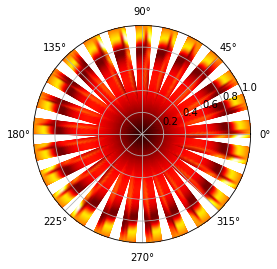

In [204]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
#cs = ax.contourf([0,0], [np.pi/2,np.pi/2], [[1,0],[1,0]],cmap='hot')
ax.scatter(np.ravel(x),np.ravel(y),c=np.ravel(v),cmap='hot')
ax.set_rmax(1)

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\ipykernel_launcher.py:117: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))


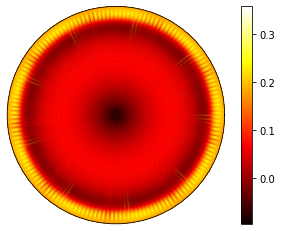

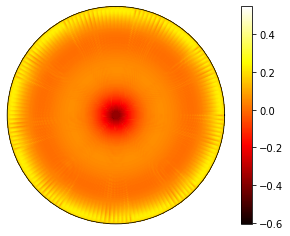

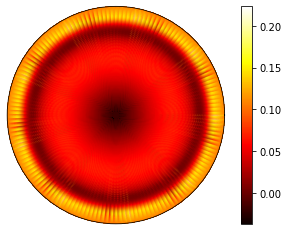

In [213]:
plot_DVR(np.array(allx))
plot_DVR(np.array(ally))
plot_DVR(np.array(allz))

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\ipykernel_launcher.py:113: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))


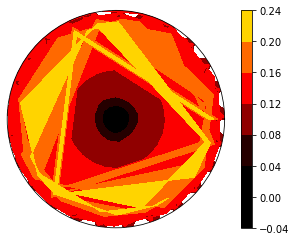

In [194]:
p,r,v = plot_DVR(np.array(allz))

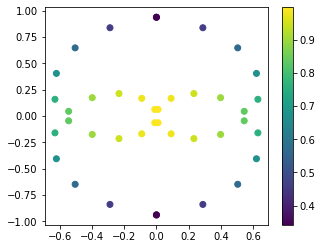

In [5]:
# Define acquisition scheme (to use normals)
v_angs = ma.generate_angles(mode='sync',alpha=70,beta=70,n_tilt=40)
norms = []
for a in v_angs:
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    n = mrot.dot([0,0,1])
    norms.append(n)
    
plt.figure(figsize=(5,4))
plt.scatter(np.take(norms,0,axis=1),np.take(norms,1,axis=1),c=np.take(norms,2,axis=1))
plt.colorbar()

44

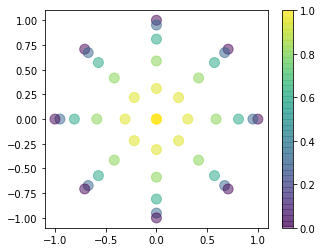

In [235]:
# Define angles to test
#v_angs = ma.generate_angles(mode='dist',alpha=90,tilt2='gamma',dist_n2=6)
v_angs = []
ax = np.linspace(-90,90,11)
az = np.linspace(-90,90,5)
for x in ax:
    for z in az[:-1]:
        v_angs.append([x,0,z])

norms = []
for a in v_angs:
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    n = mrot.dot([0,0,1])
    norms.append(n)
    
plt.figure(figsize=(5,4))
plt.scatter(np.take(norms,0,axis=1),np.take(norms,1,axis=1),c=np.take(norms,2,axis=1),s=100,alpha=.5)
plt.colorbar()
len(v_angs)

In [80]:
allx

[48,
 51,
 50,
 51,
 41,
 31,
 20,
 31,
 18,
 16,
 17,
 16,
 8,
 8,
 8,
 8,
 18,
 16,
 17,
 15,
 41,
 31,
 20,
 31,
 48,
 51,
 50,
 51]

In [253]:
allx,ally,allz = calculate_DVR(mode='sync')

[1.0, 6.123233995736766e-17, 6.123233995736766e-17]
 54%|████████████████████████████████████████████▏                                     | 42/78 [00:12<00:11,  3.25it/s]
0 44
[0.7071067811865476, 0.7071067811865476, 6.123233995736766e-17]
  5%|████▎                                                                              | 4/78 [00:00<00:08,  8.83it/s]

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\ipykernel_launcher.py:237: RuntimeWarning: invalid value encountered in arccos


 58%|███████████████████████████████████████████████▎                                  | 45/78 [00:15<00:11,  2.96it/s]
1 47
[0.0, 1.0, 6.123233995736766e-17]
 91%|██████████████████████████████████████████████████████████████████████████▋       | 71/78 [00:44<00:04,  1.58it/s]
2 73
[-0.7071067811865476, 0.7071067811865476, 6.123233995736766e-17]
 58%|███████████████████████████████████████████████▎                                  | 45/78 [00:15<00:11,  2.82it/s]
3 47
[0.9510565162951535, 5.823541592445462e-17, 0.30901699437494745]
 47%|██████████████████████████████████████▉                                           | 37/78 [00:09<00:11,  3.71it/s]
4 39
[0.6724985119639574, 0.6724985119639574, 0.30901699437494745]
  0%|                                                                                           | 0/78 [00:00<?, ?it/s]
5 2
[0.0, 0.9510565162951535, 0.30901699437494745]
 37%|██████████████████████████████▍                                                   | 29/78 [00:06<0

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=10,8 m=44 fp=6.857143 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\ipykernel_launcher.py:117: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))


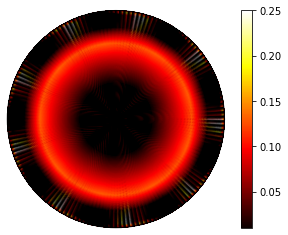

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=9,9 m=44 fp=1816.976163 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


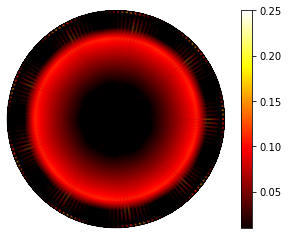

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=9,9 m=44 fp=1839.263510 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


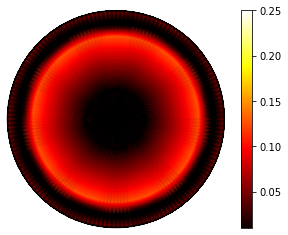

In [254]:
plot_DVR(np.array(allx))
plot_DVR(np.array(ally))
plot_DVR(np.array(allz))

In [255]:
allxd,allyd,allzd = calculate_DVR(mode='dual')

[1.0, 6.123233995736766e-17, 6.123233995736766e-17]
 85%|█████████████████████████████████████████████████████████████████████▍            | 66/78 [00:36<00:06,  1.78it/s]
0 68
[0.7071067811865476, 0.7071067811865476, 6.123233995736766e-17]
  5%|████▎                                                                              | 4/78 [00:00<00:08,  9.16it/s]

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\ipykernel_launcher.py:237: RuntimeWarning: invalid value encountered in arccos


 50%|█████████████████████████████████████████                                         | 39/78 [00:11<00:11,  3.48it/s]
1 41
[0.0, 1.0, 6.123233995736766e-17]
 83%|████████████████████████████████████████████████████████████████████▎             | 65/78 [00:36<00:07,  1.80it/s]
2 67
[-0.7071067811865476, 0.7071067811865476, 6.123233995736766e-17]
 50%|█████████████████████████████████████████                                         | 39/78 [00:11<00:11,  3.49it/s]
3 41
[0.9510565162951535, 5.823541592445462e-17, 0.30901699437494745]
 47%|██████████████████████████████████████▉                                           | 37/78 [00:10<00:11,  3.59it/s]
4 39
[0.6724985119639574, 0.6724985119639574, 0.30901699437494745]
  0%|                                                                                           | 0/78 [00:00<?, ?it/s]
5 2
[0.0, 0.9510565162951535, 0.30901699437494745]
 35%|████████████████████████████▍                                                     | 27/78 [00:05<0

In [247]:
allzd

[26,
 15,
 26,
 17,
 26,
 21,
 26,
 21,
 25,
 25,
 25,
 25,
 17,
 17,
 17,
 17,
 12,
 12,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 17,
 17,
 17,
 17,
 25,
 25,
 25,
 25,
 26,
 21,
 26,
 21,
 26,
 15,
 26,
 17]

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=10,8 m=44 fp=1.714286 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\ipykernel_launcher.py:117: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))


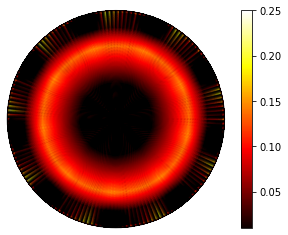

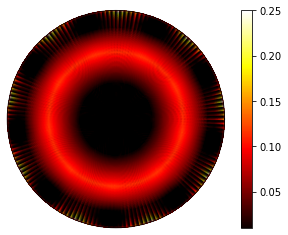

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=11,7 m=44 fp=0.759085 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


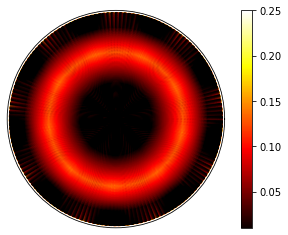

In [256]:
plot_DVR(np.array(allxd))
plot_DVR(np.array(allyd))
plot_DVR(np.array(allzd))

In [245]:
np.max(allxc)

31

In [257]:
allxc,allyc,allzc = calculate_DVR(mode='dist')

[1.0, 6.123233995736766e-17, 6.123233995736766e-17]
 37%|██████████████████████████████▍                                                   | 29/78 [00:05<00:10,  4.84it/s]
0 31
[0.7071067811865476, 0.7071067811865476, 6.123233995736766e-17]
  5%|████▎                                                                              | 4/78 [00:00<00:08,  9.00it/s]

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\ipykernel_launcher.py:237: RuntimeWarning: invalid value encountered in arccos


 32%|██████████████████████████▎                                                       | 25/78 [00:04<00:09,  5.36it/s]
1 27
[0.0, 1.0, 6.123233995736766e-17]
 29%|████████████████████████▏                                                         | 23/78 [00:04<00:09,  5.51it/s]
2 25
[-0.7071067811865476, 0.7071067811865476, 6.123233995736766e-17]
 32%|██████████████████████████▎                                                       | 25/78 [00:04<00:09,  5.35it/s]
3 27
[0.9510565162951535, 5.823541592445462e-17, 0.30901699437494745]
 37%|██████████████████████████████▍                                                   | 29/78 [00:06<00:10,  4.66it/s]
4 31
[0.6724985119639574, 0.6724985119639574, 0.30901699437494745]
  0%|                                                                                           | 0/78 [00:00<?, ?it/s]
5 2
[0.0, 0.9510565162951535, 0.30901699437494745]
 29%|████████████████████████▏                                                         | 23/78 [00:04<0

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=9,9 m=44 fp=2039.698736 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\ipykernel_launcher.py:117: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("hot"))


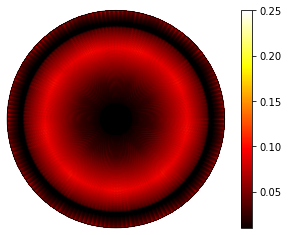

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=11,7 m=44 fp=119.047619 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


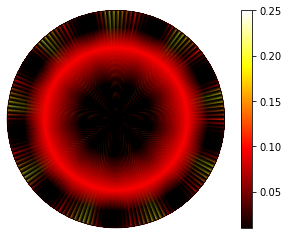

C:\Users\Sauron\anaconda3\envs\grl31-1\lib\site-packages\scipy\interpolate\_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=9,9 m=44 fp=1352.474830 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


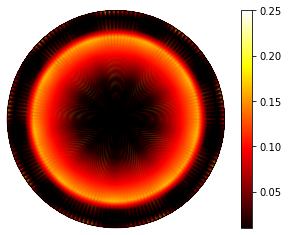

In [258]:
plot_DVR(np.array(allxc))
plot_DVR(np.array(allyc))
plot_DVR(np.array(allzc))

In [91]:
adx,ady,adz = allx,ally,allz

In [123]:
v_angs = []
ax = np.linspace(-90,90,13)
az = np.linspace(-90,90,9)
for x in ax:
    for z in az[:-1]:
        v_angs.append([x,0,z])

for i in range(len(allzd)):
    print(allx[i], v_angs[i])

53 [-90.0, 0, -90.0]
52 [-90.0, 0, -67.5]
49 [-90.0, 0, -45.0]
48 [-90.0, 0, -22.5]
53 [-90.0, 0, 0.0]
48 [-90.0, 0, 22.5]
49 [-90.0, 0, 45.0]
51 [-90.0, 0, 67.5]
51 [-75.0, 0, -90.0]
49 [-75.0, 0, -67.5]
46 [-75.0, 0, -45.0]
45 [-75.0, 0, -22.5]
48 [-75.0, 0, 0.0]
45 [-75.0, 0, 22.5]
47 [-75.0, 0, 45.0]
49 [-75.0, 0, 67.5]
39 [-60.0, 0, -90.0]
36 [-60.0, 0, -67.5]
40 [-60.0, 0, -45.0]
35 [-60.0, 0, -22.5]
34 [-60.0, 0, 0.0]
35 [-60.0, 0, 22.5]
39 [-60.0, 0, 45.0]
36 [-60.0, 0, 67.5]
25 [-45.0, 0, -90.0]
25 [-45.0, 0, -67.5]
29 [-45.0, 0, -45.0]
27 [-45.0, 0, -22.5]
27 [-45.0, 0, 0.0]
27 [-45.0, 0, 22.5]
30 [-45.0, 0, 45.0]
25 [-45.0, 0, 67.5]
15 [-30.0, 0, -90.0]
16 [-30.0, 0, -67.5]
19 [-30.0, 0, -45.0]
21 [-30.0, 0, -22.5]
21 [-30.0, 0, 0.0]
21 [-30.0, 0, 22.5]
19 [-30.0, 0, 45.0]
15 [-30.0, 0, 67.5]
10 [-15.0, 0, -90.0]
10 [-15.0, 0, -67.5]
10 [-15.0, 0, -45.0]
10 [-15.0, 0, -22.5]
10 [-15.0, 0, 0.0]
10 [-15.0, 0, 22.5]
10 [-15.0, 0, 45.0]
10 [-15.0, 0, 67.5]
8 [0.0, 0, -90.0]
8 [0

In [ ]:
# Define acquisition scheme (to use normals)
v_angs = ma.generate_angles(mode='dual',alpha=70,beta=70,tilt2='gamma',dist_n2=6)
norms = []
for a in v_angs:
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    n = mrot.dot([0,0,1])
    norms.append(n)
    
plt.figure(figsize=(5,4))
plt.scatter(np.take(norms,0,axis=1),np.take(norms,1,axis=1),c=np.take(norms,2,axis=1))
plt.colorbar()

In [ ]:
# Calculate Fourier slice representation of acquisition scheme
#final = fourier_slices3D(v_angs) # scalar
finalx,finaly,finalz = fourier_slices3D(v_angs,vector_components=True) 

In [ ]:
# Define angles to test
#v_angs = ma.generate_angles(mode='dist',alpha=90,tilt2='gamma',dist_n2=6)
v_angs = []
ax = np.linspace(-90,90,int(60/6))
az = np.linspace(-90,90,6+1)
for x in ax:
    for z in az[:-1]:
        v_angs.append([x,0,z])

norms = []
for a in v_angs:
    mrot = ma.rotation_matrix(a[0],a[1],a[2])
    n = mrot.dot([0,0,1])
    norms.append(n)
    
plt.figure(figsize=(5,4))
plt.scatter(np.take(norms,0,axis=1),np.take(norms,1,axis=1),c=np.take(norms,2,axis=1),s=2000,alpha=.5)
plt.colorbar()

In [ ]:
# For each normal, calculate the resolution at each one
# It uses an optimisation function to speed up finding the 50% coverage zone
final = copy.deepcopy(finalz)
all_shell_inds = {}
all_res = []
gsp,crd,centres = prepare_radius_search(final)
for i,n in enumerate(norms):
    opt_fun2, all_shell_inds = opt_factory(all_shell_inds)
    res = dc_ratio_opt3(crd,final,n.tolist(),'thresh',gsp,centres,all_shell_inds,thresh=1)
    print(i,res)
    all_res.append(res)

In [ ]:
d,n,N_mult=100,100,2
N = n*N_mult    
rpx = d/n
fpx = 1/rpx / N # fourier space pixel display width

myphis = []
mythetas = []

for n in norms:
    r = (n[0]**2+n[1]**2+n[2]**2)**.5
    theta = np.arctan2(n[2],(n[0]**2+n[1]**2)**0.5)
    phi = np.arctan2(n[1],n[0])
    myphis.append(phi)
    mythetas.append(theta)

# myphis=  np.array([0,90,180,270,360,  0,90,180,270,360])/np.pi*180
# mythetas=  90/np.pi*180-np.array([0,0,0,0,0, 45,45,45,45,45 ])/np.pi*180
# res=[28,28,28,28,28,  15,15,15,15,15]

# myphis=  np.array([0,90,180,270,360,  0,90,180,270,360, 45,135,225,315,  0,90])/180*np.pi
# mythetas=  np.array([0,0,0,0,0, 45,45,45,45,45,  1,1,1,1, 90,90])/180*np.pi
# res=[28,28,28,28,28,  22,22,22,22,22, 22,22,22,22,  1,1]



f = scipy.interpolate.interp2d(myphis,mythetas,all_res,kind='linear')

phis = np.linspace(0, 360, 520)
num_phis = len(phis)
thetas = np.linspace(0, 90, 180)
num_thetas = len(thetas)

values = np.zeros((num_thetas, num_phis))
for i in range(num_thetas):
    for j in range(num_phis):
        theta = np.deg2rad(thetas[i])
        phi = np.deg2rad(phis[j])
            
        values[i, j] = f(phi,theta)

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
cs = ax.contourf(phis, thetas, values*fpx,cmap='hot',vmax=0.24)
ax.set_rmax(90)
ax.set_rticks([])
#ax.set_xticks([])
cs.cmap.set_under('k')
colorbar = clippedcolorbar(cs)